In [1]:
import codecs
import json
import numpy as np
import sklearn

In [2]:
from Scripts.ProcessingEmbeddings import *
import Scripts.utils as utils

In [3]:
#Creating an embeddings object: 400k words, 50 dimensions
glove=Embeddings('Data/glove-wiki-gigaword-300.txt', gensim=False)
#word2vec=Embeddings('Data/word2vec-google-news-300.txt', gensim=False)

Loading Data/glove-wiki-gigaword-300.txt embeddings
vectors shape: (400000, 300), word2idx length: 400000, vocab length: 400000


In [4]:
#Getting the attributes of the embeddings 
vectors=glove.vectors
word2idx=glove.word2idx
vocab=glove.words
dict_vectors = glove.get_word_vector_dict()

In [5]:
#Verifying the attributes: there shouldn't be any null values
np.isnan(vectors).any()

False

In [6]:
#Removing puntuation and numbers from the embeddings
vocab_cleaned, vectors_cleaned, word2idx_cleaned, dict_vec_cleaned = glove.limit_vocab(
    vectors, word2idx, vocab)


100%|██████████| 400000/400000 [00:00<00:00, 623584.24it/s]


Size of limited vocabulary: 327185


In [7]:
#Checking if vector are normalized
np.apply_along_axis(np.linalg.norm, 1, vectors_cleaned)
#They are not!

array([5.18139682, 5.45449219, 5.91459155, ..., 5.73745479, 6.25541744,
       3.3774816 ])

## Hard-Debias Algorithm

#### Preliminaries

In [8]:
from Scripts.HardDebias import *

In [9]:
#Gender specific vocabulary from Bolukbasi's paper.
gender_specific = []
female_vocab = []
male_vocab = []
with open('./Data/male_word_file.txt') as f:
    male_vocab = [line.strip() for line in f]

with open('./Data/female_word_file.txt') as f:
    for l in f:
        female_vocab.append(l.strip())

#gender_specific = female_vocab+female_vocab

with codecs.open('./Data/gender_specific_full.json') as f:
    gender_specific.extend(json.load(f)) #1441 words


In [10]:
print('male words:', len(male_vocab))
print('female words:', len(female_vocab))
print('gender_specific',len(gender_specific))

male words: 221
female words: 221
gender_specific 1441


In [11]:
#Getting the definitional sets to calculate afterwards the gender direction. The first 10 gender sets were proposed by Bolukbasi et al. (2016)
#Definitional sets for race where proposed by Manzini et al. in Multiclass debiasing of embeddings: https://github.com/TManzini/DebiasMulticlassWordEmbedding/blob/master/Debiasing/data/vocab/race_attributes_optm.json

def_sets={
    "gender" : [
    ['she', 'he'], ['herself', 'himself'], ['her', 'his'], ['daughter', 'son'], ['girl', 'boy'],
    ['mother', 'father'], ['woman', 'man'], ['mary', 'john'], ['gal', 'guy'], ['female', 'male'],['aunt', 'uncle']],
    
    "race":[
		["black", "caucasian", "asian", "hispanic"],
		["african", "caucasian", "asian", "hispanic"],
		["black", "white", "asian", "latino"],
		["africa", "europe", "asia", "mexico"],
		["africa", "america", "china", "latin-america"],
    ]
	}

#Equalizing pairs for gender debiasing were first published by Bolukbasi et al. in https://github.com/tolga-b/debiaswe/blob/master/data/equalize_pairs.json
# Equalizing sets for race where defined by Manzini as equal to the defining set (Manzini et al., 2019.p.3)
equalizing_lists = {
    "gender": [
        ["monastery", "convent"], ["spokesman", "spokeswoman"], [
            "Catholic_priest", "nun"], ["Dad", "Mom"], ["Men", "Women"],
        ["councilman", "councilwoman"], ["grandpa", "grandma"], [
            "grandsons", "granddaughters"], ["prostate_cancer", "ovarian_cancer"],
        ["testosterone", "estrogen"], ["uncle", "aunt"], [
            "wives", "husbands"], ["Father", "Mother"], ["Grandpa", "Grandma"],
        ["He", "She"], ["boy", "girl"], ["boys", "girls"], ["brother", "sister"], [
            "brothers", "sisters"], ["businessman", "businesswoman"],
        ["chairman", "chairwoman"], ["colt", "filly"], ["congressman",
                                                        "congresswoman"], ["dad", "mom"], ["dads", "moms"], ["dudes", "gals"],
        ["ex_girlfriend", "ex_boyfriend"], ["father", "mother"], [
            "fatherhood", "motherhood"], ["fathers", "mothers"], ["fella", "granny"],
        ["fraternity", "sorority"], ["gelding", "mare"], ["gentleman", "lady"], [
            "gentlemen", "ladies"], ["grandfather", "grandmother"],
        ["grandson", "granddaughter"], ["he", "she"], ["himself", "herself"], [
            "his", "her"], ["king", "queen"], ["kings", "queens"],
        ["male", "female"], ["males", "females"], ["man", "woman"], [
            "men", "women"], ["nephew", "niece"], ["prince", "princess"],
        ["schoolboy", "schoolgirl"], ["son", "daughter"], ["sons", "daughters"], ["twin_brother", "twin_sister"]],

    "race": [
        ["black", "caucasian", "asian"],
      	["african", "caucasian", "asian"],
      	["black", "white", "asian"],
      	["africa", "america", "asia"],
      	["africa", "america", "china"],
      	["africa", "europe", "asia"]
    ]}

#Some of the words were taken from the analogies' templates from Cheng and Manzini.
#The list is not the same, however, because some of the words were not neutral, but carried some
#relation to the social categories.
neutral_words = ["manager", "executive", "doctor", "lawyer", "programmer",
                 "scientist", "soldier", "supervisor", "rancher", "janitor",
                 "firefighter", "officer", "secretary", "nurse", "clerk", "artist",
                 "homemaker", "dancer", "singer", "librarian", "maid", "hairdresser", "stylist",
                 "receptionist", "counselor", "leader", "farmer",
                 "engineer", "laborer", "teacher",
                 "slave", "musician", "runner", "criminal", "homeless",
                 "greedy", "cheap", "hairy", "liberal",
                 "judgemental", "conservative", "familial",
                 "violent", "terrorist", "dirty", "uneducated", "educated"]


#However, also the vocabulary without the gendered words from the list can be conceived as neutral, according to Bolukbasi et al.


In [12]:
#Lists of names for validation
#Adapted from Speer's tutorial on racism in sentiment analysis. http://blog.conceptnet.io/posts/2017/how-to-make-a-racist-ai-without-really-trying/
names_ethnicity = {
    # The first two lists are from the Caliskan et al. appendix describing the
    # Word Embedding Association Test.
    'White': [
        'Adam', 'Chip', 'Harry', 'Josh', 'Roger', 'Alan', 'Frank', 'Ian', 'Justin',
        'Ryan', 'Andrew', 'Fred', 'Jack', 'Matthew', 'Stephen', 'Brad', 'Greg', 'Jed',
        'Paul', 'Todd', 'Brandon', 'Hank', 'Jonathan', 'Peter', 'Wilbur', 'Amanda',
        'Courtney', 'Heather', 'Melanie', 'Sara', 'Amber', 'Crystal', 'Katie',
        'Meredith', 'Shannon', 'Betsy', 'Donna', 'Kristin', 'Nancy', 'Stephanie',
        'Bobbie-Sue', 'Ellen', 'Lauren', 'Peggy', 'Sue-Ellen', 'Colleen', 'Emily',
        'Megan', 'Rachel', 'Wendy'
    ],

    'Black': [
        'Alonzo', 'Jamel', 'Lerone', 'Percell', 'Theo', 'Alphonse', 'Jerome',
        'Leroy', 'Rasaan', 'Torrance', 'Darnell', 'Lamar', 'Lionel', 'Rashaun',
        'Tyree', 'Deion', 'Lamont', 'Malik', 'Terrence', 'Tyrone', 'Everol',
        'Lavon', 'Marcellus', 'Terryl', 'Wardell', 'Aiesha', 'Lashelle', 'Nichelle',
        'Shereen', 'Temeka', 'Ebony', 'Latisha', 'Shaniqua', 'Tameisha', 'Teretha',
        'Jasmine', 'Latonya', 'Shanise', 'Tanisha', 'Tia', 'Lakisha', 'Latoya',
        'Sharise', 'Tashika', 'Yolanda', 'Lashandra', 'Malika', 'Shavonn',
        'Tawanda', 'Yvette'
    ],
    
    # This list comes from statistics about common Hispanic-origin names in the US.
    'Hispanic': [
        'Juan', 'José', 'Miguel', 'Luís', 'Jorge', 'Santiago', 'Matías', 'Sebastián',
        'Mateo', 'Nicolás', 'Alejandro', 'Samuel', 'Diego', 'Daniel', 'Tomás',
        'Juana', 'Ana', 'Luisa', 'María', 'Elena', 'Sofía', 'Isabella', 'Valentina',
        'Camila', 'Valeria', 'Ximena', 'Luciana', 'Mariana', 'Victoria', 'Martina'
    ],
    
   
}
#Following Bolukbasi et al. Implementing notebook: https://github.com/tolga-b/debiaswe/blob/master/tutorial_example1.ipynb
names = ["Emily", "Aisha", "Anne", "Keisha", "Jill", "Tamika", "Allison", "Lakisha", "Laurie", "Tanisha", "Sarah",
         "Latoya", "Meredith", "Kenya", "Carrie", "Latonya", "Kristen", "Ebony", "Todd", "Rasheed", "Neil", "Tremayne",
         "Geoffrey", "Kareem", "Brett", "Darnell", "Brendan", "Tyrone", "Greg", "Hakim", "Matthew", "Jamal", "Jay",
         "Leroy", "Brad", "Jermaine"]
#names_group1 = [names[2 * i] for i in range(len(names) // 2)]
#names_group2 = [names[2 * i + 1] for i in range(len(names) // 2)]



In [13]:
#Preparing the definite sets for debiasing
def_set_gender=utils.prepare_def_sets_subspace(def_sets["gender"])
def_set_race=utils.prepare_def_sets_subspace(def_sets["race"])

## What's the better way to find the Bias direction
The success of hard debiasing algorithms lies on their capacity to find the appropriate bias direction. To have an idea of how good the algorithms are on that task, we'll count how many of the explicitly gendered words in the lists are identified by the gender direction. 

In [16]:
#Find the words in the female_vocab that are also in the embeddings
female_words_emb=[word for word in female_vocab if word in dict_vec_cleaned.keys()]
male_words_emb = [word for word in male_vocab if word in dict_vec_cleaned.keys()]
gender_specific_emb = [word for word in gender_specific  if word in dict_vec_cleaned.keys()]
print('Number of female words in embeddings:', len(female_words_emb))
print('Number of male words in embeddings:', len(male_words_emb))
print('Number of gender specific words in embeddings:', len(gender_specific_emb))


Number of female words in embeddings: 195
Number of male words in embeddings: 204
Number of gender specific words in embeddings: 430


In [17]:
#get the gender specific words that are not in male_words_emb nor in female_words_emb.

gender_new=[word for word in gender_specific_emb if not word in (female_words_emb+male_words_emb)]
print(len(gender_new), 'new words, that are:', gender_new)
#Because some of them are not explicitly gendered, such as teenager, twins, gonzalez, I will not use them for the analysis. 


202 new words, that are: ['teenager', 'cousin', 'mum', 'twins', 'feminist', 'eldest', 'fiancé', 'mares', 'socialite', 'fiancée', 'knight', 'babe', 'manly', 'manhood', 'granny', 'gynecologist', 'yo', 'knights', 'masculinity', 'bro', 'womens', 'stepchildren', 'matron', 'momma', 'maidens', 'goddesses', 'blondes', 'divorcee', 'fathering', 'womanhood', 'missus', 'granddad', 'gf', 'sis', 'womanizer', 'gynecological', 'stepsister', 'stepdad', 'dame', 'raspy', 'harem', 'deliveryman', 'septuagenarian', 'damsel', 'mothering', 'shes', 'auntie', 'virile', 'grandmas', 'nan', 'vixen', 'loins', 'erections', 'ter', 'virility', 'bros', 'womenfolk', 'manliness', 'patriarchs', 'earl', 'sisterly', 'countess', 'convents', 'mamas', 'yah', 'aunty', 'aunties', 'penile', 'nuh', 'mah', 'toms', 'mam', 'nana', 'coeds', 'dames', 'herdsman', 'menfolk', 'bloods', 'damsels', 'mamma', 'concubine', 'filial', 'broads', 'fianc', 'wifey', 'grandnephew', 'dowries', 'rah', 'womans', 'codger', 'courtesans', 'grandaughter', '

In [21]:
gender_new


['teenager',
 'cousin',
 'mum',
 'twins',
 'feminist',
 'eldest',
 'fiancé',
 'mares',
 'socialite',
 'fiancée',
 'knight',
 'babe',
 'manly',
 'manhood',
 'granny',
 'gynecologist',
 'yo',
 'knights',
 'masculinity',
 'bro',
 'womens',
 'stepchildren',
 'matron',
 'momma',
 'maidens',
 'goddesses',
 'blondes',
 'divorcee',
 'fathering',
 'womanhood',
 'missus',
 'granddad',
 'gf',
 'sis',
 'womanizer',
 'gynecological',
 'stepsister',
 'stepdad',
 'dame',
 'raspy',
 'harem',
 'deliveryman',
 'septuagenarian',
 'damsel',
 'mothering',
 'shes',
 'auntie',
 'virile',
 'grandmas',
 'nan',
 'vixen',
 'loins',
 'erections',
 'ter',
 'virility',
 'bros',
 'womenfolk',
 'manliness',
 'patriarchs',
 'earl',
 'sisterly',
 'countess',
 'convents',
 'mamas',
 'yah',
 'aunty',
 'aunties',
 'penile',
 'nuh',
 'mah',
 'toms',
 'mam',
 'nana',
 'coeds',
 'dames',
 'herdsman',
 'menfolk',
 'bloods',
 'damsels',
 'mamma',
 'concubine',
 'filial',
 'broads',
 'fianc',
 'wifey',
 'grandnephew',
 'dowries

Getting the gender direction to be able to identify words that are biase. The first one centralizes the definite sets, while the second one doesn't. 

In [72]:
#getting the gender directions
gen_dir_centralized=identify_bias_subspace(dict_vec_cleaned, def_set_gender, 1, centralizing=True)
gen_dir=identify_bias_subspace(dict_vec_cleaned, def_set_gender, 1, centralizing=False)

#flattening them
gen_dir_centralized_flat=np.squeeze(gen_dir_centralized)
gen_dir_flat=np.squeeze(gen_dir)


Length of vectors set: 22
Running PCA with 1 components
Length of vectors set: 11
Running PCA with 1 components


Functions to get the most biased words in the dataset:

In [187]:
#compute the similarity of a word through cosine similarity to the bias direction
from operator import itemgetter
def compute_similarity_to_bias_direction(dic_vec, bias_dir):
    #bias_direction = bias_dir / np.linalg.norm(bias_dir)
    similarity = {}
    for word in dic_vec.keys():
    #    dic_vec[word]=dic_vec[word]/np.linalg.norm(dic_vec[word])
        similarity[word] = utils.cosine_similarity(bias_dir, dic_vec[word])
    return similarity


#function to get the most biased words in dict_vec_cleaned rated my similarity to the bias direction


def get_most_biased_words_similarity(similarity, n_words=2500):
    #get the absolute values of the similarity values
    similarity = {word: abs(sim) for word, sim in similarity.items()}
    #sort the similarity values
    sorted_similarity = sorted(
        similarity.items(), key=itemgetter(1), reverse=True)
    biased_words = [word for word, bias in sorted_similarity[:n_words]]
    neutral_words = [word for word, bias in sorted_similarity[-n_words:]]
    return biased_words, neutral_words


In [188]:
#Compute the similarity to the bias direction
from Scripts.Evaluation import compute_gender_simple_bias, compute_similarity_to_bias_direction
similarity=compute_similarity_to_bias_direction(dict_vec_cleaned, gen_dir_flat)
similarity_centralized=compute_similarity_to_bias_direction(dict_vec_cleaned, gen_dir_centralized_flat)
simple_gender_bias=compute_gender_simple_bias(dict_vec_cleaned, dict_vec_cleaned['he'], dict_vec_cleaned['she'])

In [194]:
#count how many female_words_emb and male_words_emb are in the biased_words
def count_gendered_words_in_most_biased(female_words, male_words, biased_words):
    count_female = 0
    count_male = 0
    data = {}
    for word in set(biased_words):
        if word in set(female_words):
            count_female += 1
        if word in set(male_words):
            count_male += 1

    data.update({'number_words': len(biased_words), 'count_female': count_female, 
                 'recall_female': count_female/len(female_words),
                 'precision_female': count_female/len(biased_words),
                 'count_male': count_male, 'recall_male': count_male/len(male_words),
                 'precision_male': count_male/len(biased_words)})
    return data


In [195]:
#function to get a dataframe with the counts for experiments with different number of words
def get_counts_gendered_words_per_direction(similarity, n_words):
   
    dict_results={}
    last_biased_words=[]
    for i in range(1, 11):
        number_words=int(n_words*i/100)
        #getting the most biased words and words that are neutral
        biased_words, _ = get_most_biased_words_similarity(
            similarity, number_words)
        dict_counts=count_gendered_words_in_most_biased(
            female_words_emb, male_words_emb, biased_words)
        #add the dict_counts to the dict_results
        dict_results.update({str(i)+'%': dict_counts})
        last_biased_words=biased_words
    return dict_results, last_biased_words

In [196]:
dict_similarity, biased_words_similarity=get_counts_gendered_words_per_direction(similarity, n_words=len(vocab_cleaned))
dict_similarity_cent, biased_words_similarity_cent = get_counts_gendered_words_per_direction(
    similarity_centralized, n_words=len(vocab_cleaned))
dict_similarity_simple, biased_words_simple = get_counts_gendered_words_per_direction(
    simple_gender_bias, n_words=len(vocab_cleaned))


In [197]:
#get a dataframe from dic_similarity
def get_dataframe_from_dict(dict_similarity):
    df = pd.DataFrame.from_dict(dict_similarity, orient='index')
    df = df.reset_index()
    df = df.rename(columns={'index': 'percentage'})
    return df


In [198]:
get_dataframe_from_dict(dict_similarity)


,percentage,number_words,count_female,recall_female,precision_female,count_male,recall_male,precision_male
0,1%,3271,32,0.164103,0.009783,12,0.058824,0.003669
1,2%,6543,35,0.179487,0.005349,12,0.058824,0.001834
2,3%,9815,36,0.184615,0.003668,14,0.068627,0.001426
3,4%,13087,41,0.210256,0.003133,16,0.078431,0.001223
4,5%,16359,43,0.220513,0.002629,20,0.098039,0.001223
5,6%,19631,47,0.241026,0.002394,22,0.107843,0.001121
6,7%,22902,49,0.251282,0.002140,24,0.117647,0.001048
7,8%,26174,51,0.261538,0.001948,24,0.117647,0.000917
8,9%,29446,52,0.266667,0.001766,25,0.122549,0.000849
9,10%,32718,56,0.287179,0.001712,29,0.142157,0.000886


In [199]:
get_dataframe_from_dict(dict_similarity_cent)


,percentage,number_words,count_female,recall_female,precision_female,count_male,recall_male,precision_male
0,1%,3271,73,0.374359,0.022317,16,0.078431,0.004891
1,2%,6543,88,0.451282,0.013449,19,0.093137,0.002904
2,3%,9815,101,0.517949,0.010290,27,0.132353,0.002751
3,4%,13087,114,0.584615,0.008711,31,0.151961,0.002369
4,5%,16359,118,0.605128,0.007213,32,0.156863,0.001956
5,6%,19631,124,0.635897,0.006317,37,0.181373,0.001885
6,7%,22902,130,0.666667,0.005676,38,0.186275,0.001659
7,8%,26174,133,0.682051,0.005081,41,0.200980,0.001566
8,9%,29446,135,0.692308,0.004585,46,0.225490,0.001562
9,10%,32718,137,0.702564,0.004187,48,0.235294,0.001467


In [200]:
get_dataframe_from_dict(dict_similarity_simple)


,percentage,number_words,count_female,recall_female,precision_female,count_male,recall_male,precision_male
0,1%,3271,75,0.384615,0.022929,6,0.029412,0.001834
1,2%,6543,93,0.476923,0.014214,17,0.083333,0.002598
2,3%,9815,105,0.538462,0.010698,21,0.102941,0.002140
3,4%,13087,112,0.574359,0.008558,22,0.107843,0.001681
4,5%,16359,115,0.589744,0.007030,24,0.117647,0.001467
5,6%,19631,121,0.620513,0.006164,26,0.127451,0.001324
6,7%,22902,125,0.641026,0.005458,32,0.156863,0.001397
7,8%,26174,133,0.682051,0.005081,37,0.181373,0.001414
8,9%,29446,136,0.697436,0.004619,38,0.186275,0.001290
9,10%,32718,139,0.712821,0.004248,40,0.196078,0.001223


In [201]:
#GETTING THE RESULTS ONE BY ONE
#getting the most biased words and words that are neutral in the non-centralized case
biased_words, neutral_words=get_most_biased_words_similarity(similarity, n_words=40000)
count_gendered_words_in_most_biased(
    female_words_emb+male_words_emb, gender_specific_emb, biased_words)

#getting the most biased words and words that are neutral in the centralized case
biased_words_centralized, neutral_words_centralized = get_most_biased_words_similarity(
    similarity_centralized, n_words=40000)
count_gendered_words_in_most_biased(
    female_words_emb, male_words_emb, biased_words_centralized)

#getting the most biased words and words that are neutral in the baseline
_, _, female_simple, male_simple, _ = utils.getting_biased_words(
    simple_gender_bias, def_sets['gender'], 20000, word2idx)

count_gendered_words_in_most_biased(female_words_emb, male_words_emb,female_simple+male_simple )

{'number_words': 40000,
 'count_female': 123,
 'recall_female': 0.6307692307692307,
 'precision_female': 0.003075,
 'count_male': 85,
 'recall_male': 0.4166666666666667,
 'precision_male': 0.002125}

It looks that the centralized algorithm gets more balanced results than the non-centralized one with respect to the interpretable baseline. Interestingly, all directions are very bad at picking male specific words. This might be because women's words have a larger component on the 'bias direction' which essentially shows that the dataset of embeddings regards the masculine as more 'neutral' consistent with the findings of Caliskan, 2022. Let's take a look at the words that get identified as biased to see whether those words actually make sense. 

#### Let's plot the results

In [176]:
import pandas as pd
#get a dataframe with the bias scores of the female_words_emb and male_words_emb in the similarity, similarity_centralized and simple_gender_bias
def get_df_bias_scores(word_list, similarity, similarity_centralized,simple_bias_score):
    scores={}
    for word in word_list:
        scores[word] = {"similarity_score": (similarity[word]),
                        "centralized_similarity_score": (similarity_centralized[word]),
                        "simple_bias_score": simple_bias_score[word]}
    df=pd.DataFrame.from_dict(scores, orient='index')
    return df



Gets the most biased words by the simple metric and compares the scores: to see which gender direction allow to get a better sense of which words are feminine and which are masculine: 

In [177]:
df_female=get_df_bias_scores(female_words_emb, similarity, similarity_centralized,simple_gender_bias)
df_male=get_df_bias_scores(male_words_emb, similarity, similarity_centralized,simple_gender_bias)

In [178]:
#sort the dataframe according to the simple_gender_bias column
most_female_bias=df_female.sort_values(by=['simple_bias_score'], ascending=False, inplace=True)
most_male_bias=df_male.sort_values(by=['simple_bias_score'], ascending=True, inplace=True)

In [179]:
#plot a bar plot of the top 20 most biased words with all the scores of the three methods
import plotly_express as px

def plot_top_biased_words(df, n_words=20):
    df_top=df.head(n_words)
    #remove the simple_bias_score column
    #df_top=df_top.drop(columns=['simple_bias_score'])
    df_top=df_top.reset_index()
    df_top=df_top.rename(columns={'index': 'word'})
    df_top=df_top.melt(id_vars=['word'], var_name='score_type', value_name='score')
    fig = px.bar(df_top, x="word", y="score", color="score_type", barmode="group")
    fig.show()


plot_top_biased_words(df_female, n_words=20)
plot_top_biased_words(df_male, n_words=20)


Now, let's look at what the 

In [190]:
#turn the similarity scores into a dataframe to find the 20 words with the highest similarity score
df_similarity=pd.DataFrame.from_dict(similarity, orient='index')
df_similarity=df_similarity.rename(columns={0: 'similarity_score'})
df_similarity.sort_values(by=['similarity_score'], ascending=False, inplace=True)
df_similarity_female=df_similarity.head(20)
df_similarity_male=df_similarity.tail(20)

print('Top biased words according to the similarity score:',biased_words[:20])

#turn the centralized similarity scores into a dataframe to find the 20 words with the highest similarity score
df_similarity_centralized=pd.DataFrame.from_dict(similarity_centralized, orient='index')
df_similarity_centralized=df_similarity_centralized.rename(columns={0: 'similarity_score'})
df_similarity_centralized.sort_values(by=['similarity_score'], ascending=False, inplace=True)
df_centralized_female= df_similarity_centralized.head(20)
df_centralized_male=df_similarity_centralized.tail(20)

print('Top biased words according to the centralized similarity score:',biased_words_centralized[:20])

#simple_biased = {word: abs(sim) for word, sim in simple_gender_bias.items()}
df_simple_bias = pd.DataFrame.from_dict(simple_gender_bias, orient='index')
df_simple_bias=df_simple_bias.rename(columns={0: 'simple_bias_score'})
df_simple_bias.sort_values(by=['simple_bias_score'], ascending=False, inplace=True)
df_simple_fem=df_simple_bias.head(20)
df_simple_masc=df_simple_bias.tail(20)
print('Top biased words simple_score', list(df_simple_bias.head(10).index)+list(df_simple_bias.tail(10).index))



Top biased words according to the similarity score: ['gal', 'guy', 'thing', 'pretty', 'really', 'somebody', 'everyone', 'everybody', 'woman', 'guys', 'girl', 'else', 'tell', 'you', 'something', 'she', 'maybe', 'someone', 'always', 'nice']
Top biased words according to the centralized similarity score: ['schorpen', 'lactating', 'kuppinger', 'selecky', 'millerwise', 'jeria', 'hamoaze', 'actress', 'chromatid', 'okitundu', 'john', 'binah', 'sasami', 'sukmawati', 'businesswoman', 'achouri', 'tallchief', 'lengsfeld', 'pregnant', 'congresswoman']
Top biased words simple_score ['her', 'okitundu', 'countrywoman', 'actress', 'diva', 'schorpen', 'meye', 'herself', 'svetlana', 'jeria', 'mlb', 'football', 'defensive', 'parcells', 'chiefs', 'nfl', 'cardinals', 'himself', 'his', 'he']


In [205]:
#plot the top 20 most biased words according to the similarity score
import plotly_express as px
def plot_top_biased_words(df, n_words=20):
    df_top=df.head(n_words)
    #remove the simple_bias_score column
    #df_top=df_top.drop(columns=['simple_bias_score'])
    df_top=df_top.reset_index()
    df_top=df_top.rename(columns={'index': 'word'})
    df_top=df_top.melt(id_vars=['word'], var_name='score_type', value_name='score')
    fig = px.bar(df_top, y="word", x="score", color="score_type", barmode="group", orientation='h')
    fig.show()


In [206]:
plot_top_biased_words(df_similarity_male, n_words=20)
plot_top_biased_words(df_similarity_female, n_words=20)


In [207]:
plot_top_biased_words(df_simple_fem, n_words=20)
plot_top_biased_words(df_simple_masc, n_words=20)


In [208]:
plot_top_biased_words(df_centralized_female, n_words=20)
plot_top_biased_words(df_centralized_male, n_words=20)

## Other attempts

In [56]:
#get a histogram of the similarity.values()
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

def plot_histogram(similarity, title):
    plt.hist(similarity.values())
    plt.title(title)
    plt.show()

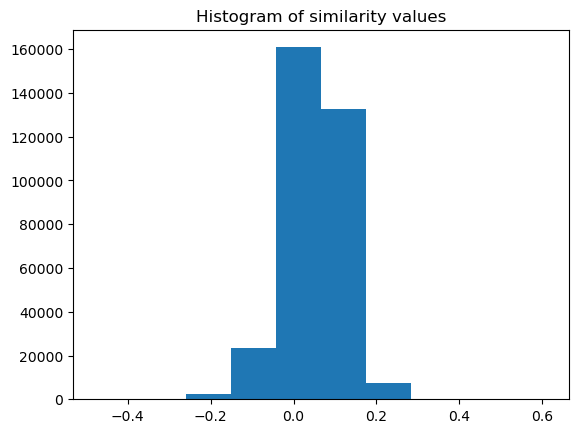

In [57]:
plot_histogram(similarity, 'Histogram of similarity values')

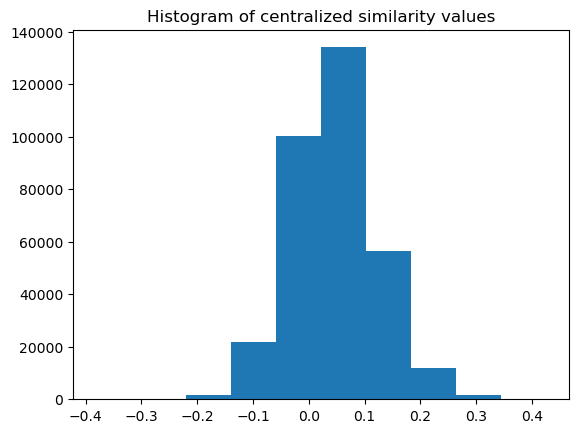

In [58]:
plot_histogram(similarity_centralized, 'Histogram of centralized similarity values')


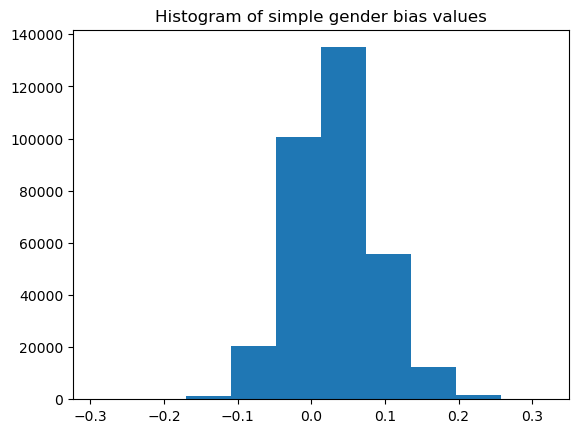

In [59]:
plot_histogram(simple_gender_bias, 'Histogram of simple gender bias values')


In [60]:
#get the words in similirity that have values 0
def get_words_with_value_zero(similarity):
    words=[]
    for word in similarity.keys():
        if np.allclose(similarity[word],0.5):
            words.append(word)
    return words

In [61]:
get_words_with_value_zero(similarity)

[]

## Testing Bias Direction from Scratch

In [ ]:

gender_dir=identify_bias_subspace(dict_vec_cleaned, def_set_gender, 1, centralizing=True)

gender_dir = np.squeeze(gender_dir)
gender_dir

race_dir=identify_bias_subspace(dict_vec_cleaned, def_set_race, 1, centralizing=True)

race_dir = np.squeeze(race_dir)
race_dir

wv_gender=neutralize_words(vocab_cleaned, vectors, word2idx_cleaned, gender_dir)
wv_gender
equalize_words(wv_gender, vocab_cleaned, word2idx_cleaned,
               equalizing_lists['gender'], gender_dir)

wv_race=neutralize_words(vocab_cleaned, vectors, word2idx_cleaned, race_dir)
wv_race
equalize_words(wv_race, vocab_cleaned, word2idx_cleaned,
               equalizing_lists['race'], race_dir)

wv_race.shape
gender_dict=get_debiased_dict(wv_gender, word2idx_cleaned)
race_dict=get_debiased_dict(wv_race, word2idx_cleaned)
len(word2idx_cleaned)
k_gender= get_k_nearest_neighbors(random_words, gender_dict, list(gender_dict.keys()), wv_gender, word2idx_cleaned, k=50)
k_race= get_k_nearest_neighbors(random_words, race_dict, list(race_dict.keys()), wv_race, word2idx_cleaned, k=50)
k_gender[random_words[0]]
k_race[random_words[0]]==k_gender[random_words[0]]
#get the first element of each tuple in the list k_race[random_words[0]]
first_race=[k_race[random_words[0]][i][0] for i in range(len(k_race[random_words[0]]))]
first_gender = [k_gender[random_words[0]][i][0]
              for i in range(len(k_gender[random_words[0]]))]


[first_race[i]==first_gender[i] for i in range(len(first_gender))]
gen_freq = get_frequency_original_networks(
    random_words, list_neigh, gender_dict, list(gender_dict.keys()), wv_gender, word2idx_cleaned, neighbours_num=50)

race_freq = get_frequency_original_networks(
    random_words, list_neigh, race_dict, list(race_dict.keys()), wv_race, word2idx_cleaned, neighbours_num=50)

gen_freq==race_freq